## Задача классификации

<b>В рамках данной работы будут выполнены следующие задачи:</b>
    
    1) Предобработка данных;
    2) Построение модели классификации используя:
        - Наивный прогноз;
        - Метод ближайших соседей:
            - По трем соседям;
            - По пяти соседям;
            - По семи соседям;
    3) Использование метода шкалирования (MinMaxScaller);
    4) Оценка моделей (F1, precision, recall);
        
        
        

Будем предсказывать удовлетворенность студентов их программой (`LikeDegree`)

In [372]:
#Импортируем нужные библиотеки:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
plt.style.use('ggplot')
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.metrics import precision_score, recall_score, f1_score


import warnings
warnings.filterwarnings('ignore')


### Предобработка данных


In [373]:
 
sb = pd.read_csv('Student_Behaviour.csv')
sb.head(5)


,CertificationCourses,Gender,Department,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,Hobbies,DailyStudingTime,PreferToStudyIn,SalaryExpectation,LikeDegree,CareerBasedonDegree,GamesSpendingTime,TravellingTime,StressLevel,FinancialStatus,PartTimeJob?
0,No,Male,BCA,100.0,58.0,79.0,65.0,80.0,Video Games,0 - 30 minute,Morning,40000,No,50%,1.30 - 2 hour,30 - 60 minutes,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.0,70.0,Cinema,30 - 60 minute,Morning,15000,Yes,75%,1 - 1.30 hour,0 - 30 minutes,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,69.5,61.0,55.0,Cinema,1 - 2 Hour,Anytime,13000,Yes,50%,More than 2 hour,30 - 60 minutes,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.0,58.0,Reading books,1 - 2 Hour,Anytime,1500000,No,50%,1.30 - 2 hour,0 - 30 minutes,Bad,good,No
4,No,Male,BCA,170.0,54.0,40.0,65.0,30.0,Video Games,30 - 60 minute,Morning,50000,Yes,25%,1.30 - 2 hour,30 - 60 minutes,Good,good,No


In [374]:
sb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CertificationCourses  235 non-null    object 
 1   Gender                235 non-null    object 
 2   Department            235 non-null    object 
 3   Height(CM)            235 non-null    float64
 4   Weight(KG)            235 non-null    float64
 5   10Mark                235 non-null    float64
 6   12Mark                235 non-null    float64
 7   CollegeMark           235 non-null    float64
 8   Hobbies               235 non-null    object 
 9   DailyStudingTime      235 non-null    object 
 10  PreferToStudyIn       235 non-null    object 
 11  SalaryExpectation     235 non-null    int64  
 12  LikeDegree            235 non-null    object 
 13  CareerBasedonDegree   235 non-null    object 
 14  GamesSpendingTime     235 non-null    object 
 15  TravellingTime        2

In [375]:
#Заметил, что колонка TravellingTime почему-то не считывается при запросе "sb.TravellingTime"
#=> Переименуем:
sb = sb.rename(columns={'TravellingTime ': 'TravellingTime'}) 

In [376]:
sb.TravellingTime #Теперь работает

0      30 - 60 minutes
1       0 - 30 minutes
2      30 - 60 minutes
3       0 - 30 minutes
4      30 - 60 minutes
            ...       
230    30 - 60 minutes
231    30 - 60 minutes
232      2.30 - 3 hour
233      2.30 - 3 hour
234      2.30 - 3 hour
Name: TravellingTime, Length: 235, dtype: object

Проверим на наличие пропусков:

In [377]:

sb.isnull().sum() 


CertificationCourses    0
Gender                  0
Department              0
Height(CM)              0
Weight(KG)              0
10Mark                  0
12Mark                  0
CollegeMark             0
Hobbies                 0
DailyStudingTime        0
PreferToStudyIn         0
SalaryExpectation       0
LikeDegree              0
CareerBasedonDegree     0
GamesSpendingTime       0
TravellingTime          0
StressLevel             0
FinancialStatus         0
PartTimeJob?            0
dtype: int64

Дубликаты:

In [378]:
sb.duplicated().sum()

0

Проверка на корректность типов данных:

In [379]:
sb.dtypes

CertificationCourses     object
Gender                   object
Department               object
Height(CM)              float64
Weight(KG)              float64
10Mark                  float64
12Mark                  float64
CollegeMark             float64
Hobbies                  object
DailyStudingTime         object
PreferToStudyIn          object
SalaryExpectation         int64
LikeDegree               object
CareerBasedonDegree      object
GamesSpendingTime        object
TravellingTime           object
StressLevel              object
FinancialStatus          object
PartTimeJob?             object
dtype: object

In [380]:
#Приведем CareerBasedonDegree к числовому формату:

sb.CareerBasedonDegree = (sb.CareerBasedonDegree.apply(lambda x: str(x).rstrip('%'))).astype('float64')/100
sb.CareerBasedonDegree #Пример проделанного преобразования: 50% --> 0.50


0      0.50
1      0.75
2      0.50
3      0.50
4      0.25
       ... 
230    0.50
231    0.75
232    0.50
233    0.75
234    0.75
Name: CareerBasedonDegree, Length: 235, dtype: float64

В датасете есть 3 поля, с суффиксом `Time`, данные в них строковые, которые означают временной интервал. Извлечем минимальное время(левую границу интервала) для каждой из этих переменных и переведем в минуты:

In [381]:

sb[[x for x in list(sb) if 'Time' in x]] #Выведем все поля с суффиксом Time



,DailyStudingTime,GamesSpendingTime,TravellingTime,PartTimeJob?
0,0 - 30 minute,1.30 - 2 hour,30 - 60 minutes,No
1,30 - 60 minute,1 - 1.30 hour,0 - 30 minutes,No
2,1 - 2 Hour,More than 2 hour,30 - 60 minutes,No
3,1 - 2 Hour,1.30 - 2 hour,0 - 30 minutes,No
4,30 - 60 minute,1.30 - 2 hour,30 - 60 minutes,No
...,...,...,...,...
230,30 - 60 minute,More than 2 hour,30 - 60 minutes,No
231,2 - 3 hour,30 - 60 Minute,30 - 60 minutes,No
232,30 - 60 minute,30 - 60 Minute,2.30 - 3 hour,No
233,0 - 30 minute,More than 2 hour,2.30 - 3 hour,No


In [382]:

st, gm, trvl = [], [], [] #В этих листах возьму нужные индексы
nst, ngm, ntrvl = [], [], [] #В этих - переведу все в минуты


#DailyStudingTime:
for i in sb.DailyStudingTime:
    i = i.split()
    if i[0] in ('More', 'more'):
        st.append(i[-2]+' '+i[-1])
    else: st.append(i[0]+' '+i[-1])

for j in st:
    j = j.split()
    if j[-1] in ('Hour', 'hour'):
        nst.append(float(j[0])*60)
    else: nst.append(int(j[0]))
        

        
#GamesSpendingTime:        
for i in sb.GamesSpendingTime:
    i = i.split()
    if i[0] in ('More', 'more'):
        gm.append(i[-2]+' '+i[-1])
    else: gm.append(i[0]+' '+i[-1])
        
for j in gm:
    j = j.split()
    if j[-1] in ('Hour', 'hour'):
        ngm.append(float(j[0])*60)
    else: ngm.append(int(j[0]))        

        
        
#TravellingTime:       
for i in sb.TravellingTime:
    i = i.split()
    if i[0] in ('More', 'more'):
        trvl.append(i[-2]+' '+i[-1])
    else: trvl.append(i[0]+' '+i[-1])
    
for j in trvl:
    j = j.split()
    if j[-1] in ('Hour', 'hour'):
        ntrvl.append(float(j[0])*60)
    else: ntrvl.append(int(j[0])) 



In [383]:

sb['Stud_time'], sb['Game_time'], sb['Travel_time'] = nst, ngm, ntrvl #Внесу листы в датафрейм
sb[[x for x in list(sb) if 'time' in x]] #Визуал (Все данные в минутах)



,Stud_time,Game_time,Travel_time
0,0.0,78.0,30.0
1,30.0,60.0,0.0
2,60.0,120.0,30.0
3,60.0,78.0,0.0
4,30.0,78.0,30.0
...,...,...,...
230,30.0,120.0,30.0
231,120.0,30.0,30.0
232,30.0,30.0,138.0
233,0.0,120.0,138.0


In [384]:
sb = sb.drop(columns=['DailyStudingTime', 'GamesSpendingTime', 'TravellingTime'])#дропну старые
sb[[x for x in list(sb) if 'Time' in x]] #Проверка того, что прошлых столбцов не осталось

,PartTimeJob?
0,No
1,No
2,No
3,No
4,No
...,...
230,No
231,No
232,No
233,No


In [385]:
sb.head(15) #Итоговый вид датафрейма

,CertificationCourses,Gender,Department,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,Hobbies,PreferToStudyIn,SalaryExpectation,LikeDegree,CareerBasedonDegree,StressLevel,FinancialStatus,PartTimeJob?,Stud_time,Game_time,Travel_time
0,No,Male,BCA,100.0,58.0,79.0,65.00,80.0,Video Games,Morning,40000,No,0.50,Bad,Bad,No,0.0,78.0,30.0
1,No,Female,BCA,90.0,40.0,70.0,80.00,70.0,Cinema,Morning,15000,Yes,0.75,Bad,Bad,No,30.0,60.0,0.0
2,Yes,Male,BCA,159.0,78.0,69.5,61.00,55.0,Cinema,Anytime,13000,Yes,0.50,Awful,Bad,No,60.0,120.0,30.0
3,Yes,Female,BCA,147.0,20.0,70.0,59.00,58.0,Reading books,Anytime,1500000,No,0.50,Bad,good,No,60.0,78.0,0.0
4,No,Male,BCA,170.0,54.0,40.0,65.00,30.0,Video Games,Morning,50000,Yes,0.25,Good,good,No,30.0,78.0,30.0
5,Yes,Female,BCA,139.0,33.0,90.0,75.00,70.0,Cinema,Night,20000,Yes,0.50,Bad,good,No,30.0,30.0,0.0
6,Yes,Male,BCA,165.0,50.0,70.0,63.00,3.0,Reading books,Morning,15000,Yes,0.75,Good,good,No,60.0,60.0,60.0
7,No,Male,BCA,152.0,43.0,61.6,61.67,75.0,Sports,Morning,25000,Yes,0.50,Good,good,No,60.0,60.0,60.0
8,No,Male,BCA,190.0,85.0,88.2,67.50,60.0,Video Games,Morning,20000,Yes,0.75,Bad,Bad,No,0.0,78.0,60.0
9,No,Male,BCA,150.0,84.0,60.0,65.00,70.0,Video Games,Anytime,20000,Yes,0.75,Good,good,No,0.0,30.0,30.0


Выберем непрерывные переменные, которые будут использоваться для предсказания целевой переменной с помощью knn

In [386]:

rv = sb.select_dtypes(include=['float64', 'int64']).columns.tolist()

rv #выделим в список все челочисленные значения.


['Height(CM)',
 'Weight(KG)',
 '10Mark',
 '12Mark',
 'CollegeMark',
 'SalaryExpectation',
 'CareerBasedonDegree',
 'Stud_time',
 'Game_time',
 'Travel_time']

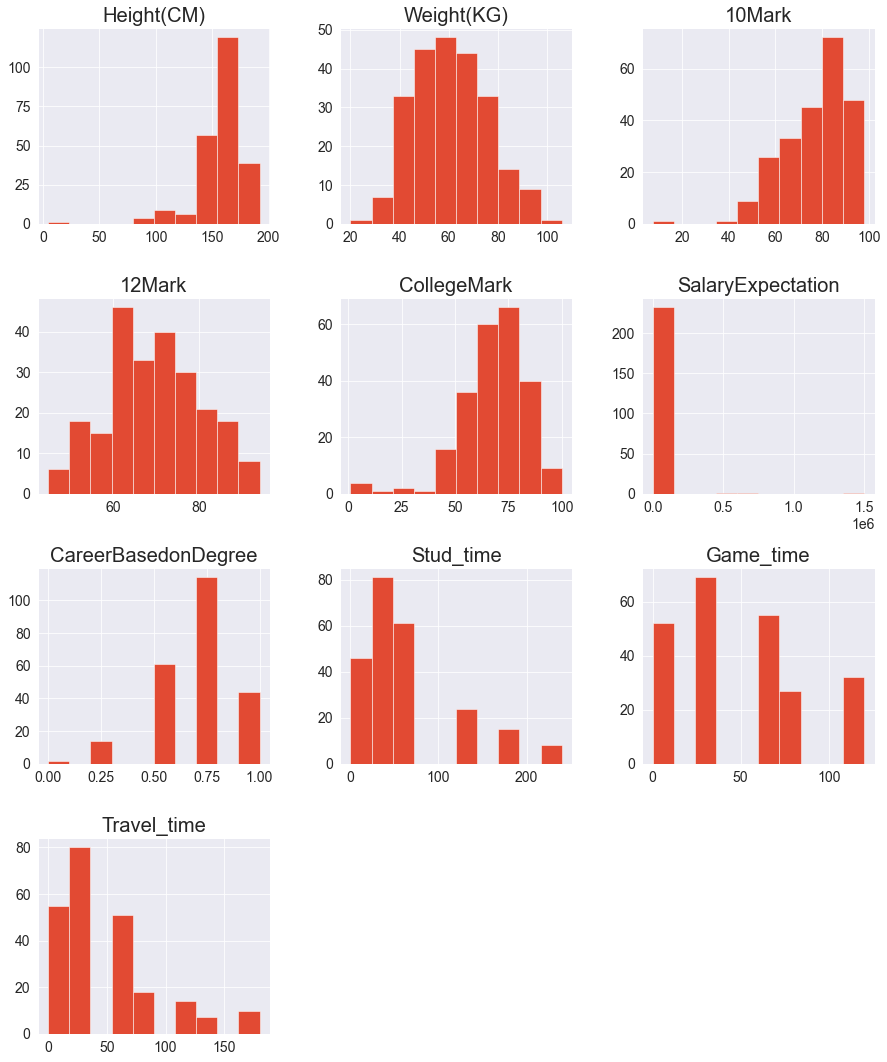

In [400]:

plt.rcParams['font.size'] = 14
_ = sb[rv].hist(figsize=(15,18.5)) #Рассмотрим распределение выделенных признаков
plt.subplots_adjust(wspace=0.3, hspace=0.38)


#Похоже, что некоторые признаки имеют выбросы: Height, 10Mark, Salary 

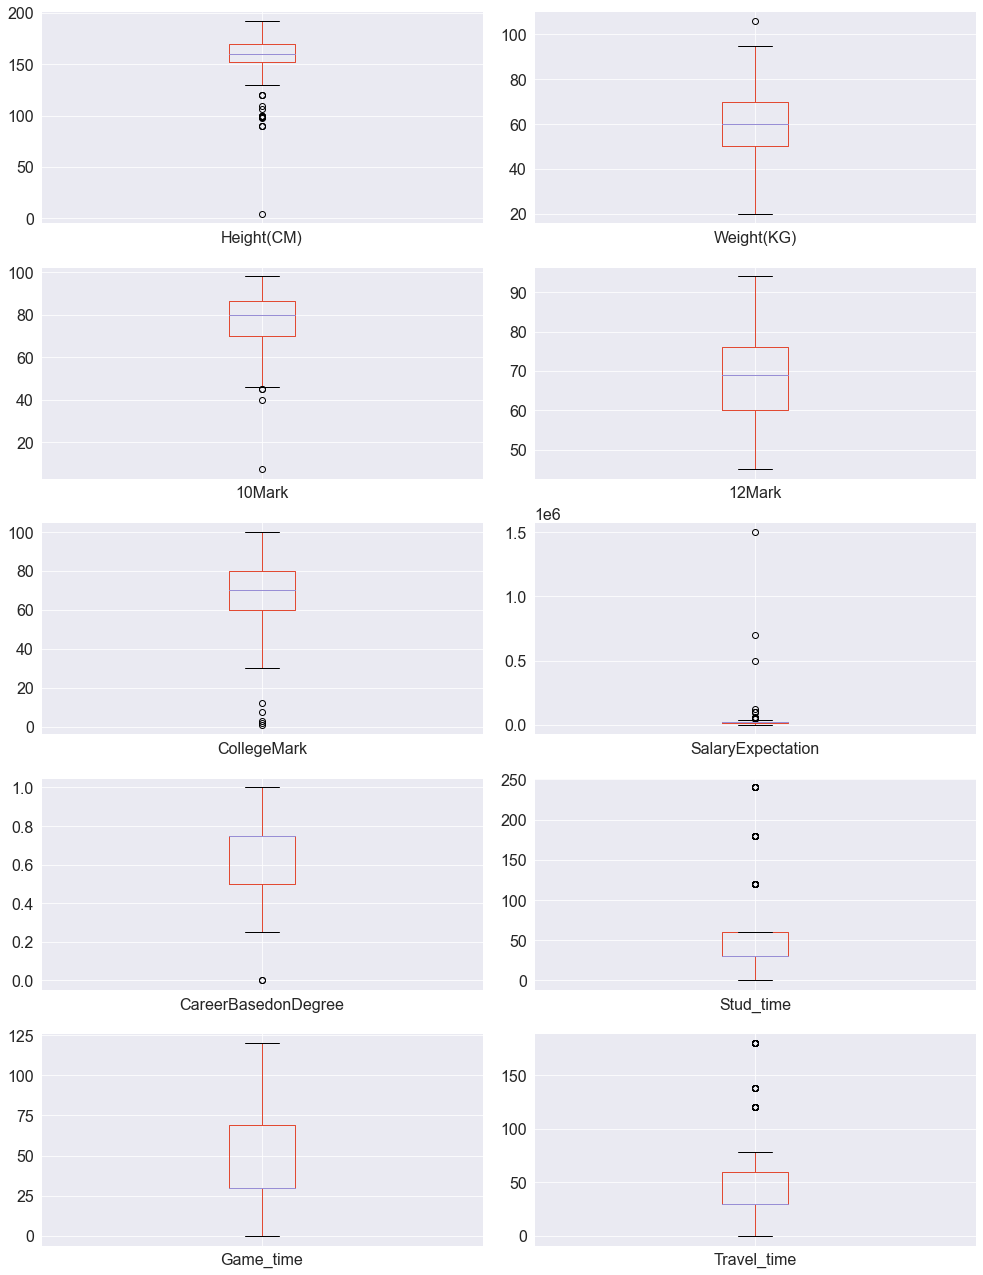

In [401]:
# Посмотрим на наличие выбросов подробнее:

plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(5,2, figsize=(14, 18))

for i, val in enumerate(rv):
    ax = plt.subplot(5, 2, i+1)
    sb.boxplot(val, ax=ax)

    
fig.tight_layout(h_pad=0.4)


#Почти все переменные имеют выбросы (все, кроме двух)
#(Пока не будем их удалять, тк. наблюдений итак мало)

---

<b>Рассмотрим как распределена целевая переменная, выбранная по условию задания:</b>

<AxesSubplot:>

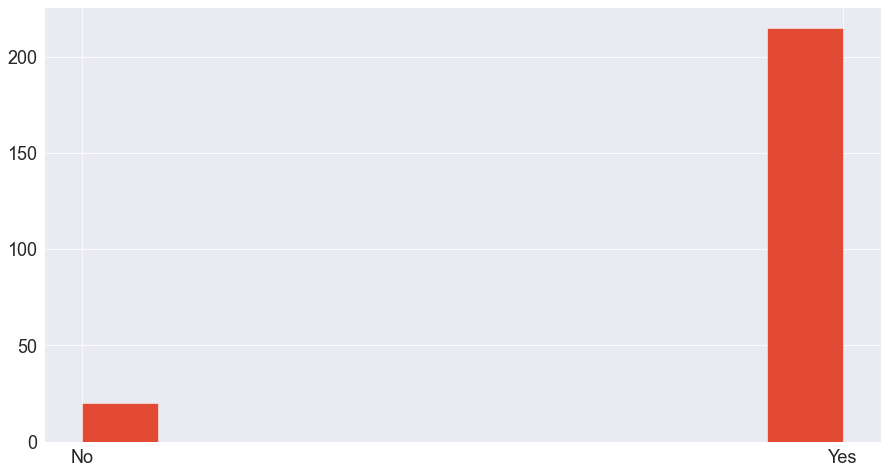

In [265]:

Y = sb.LikeDegree
Y.hist(figsize=(15,8), xlabelsize=18, ylabelsize=18)

#Бернуллиевское распределение с сильным диссбалансом классов


In [266]:
Y.describe() #Еще один способ в данной ситуации проверить распределение классов

count     235
unique      2
top       Yes
freq      215
Name: LikeDegree, dtype: object


Как видно по результатам двух тестов, ответов "ДА"(215) гораздо больше, чем ответов "НЕТ"(20).
Это говорит о том, что присутствует дисбаланс классов. 

В таком случае, бессмысленно использовать Accuracy, тк он является бесполезным при неравных классах.
Вместо этого, гораздо полезнее оценивать модель в дальнейшем через Recall и Precision. 
F-measure тоже подойдет.



---

Переведем целевую переменную в числовой формат

In [267]:
Y = Y.map({'Yes':1, 'No':0})

In [268]:
Y.value_counts() #Как видно, все прошло успешно

1    215
0     20
Name: LikeDegree, dtype: int64

<AxesSubplot:>

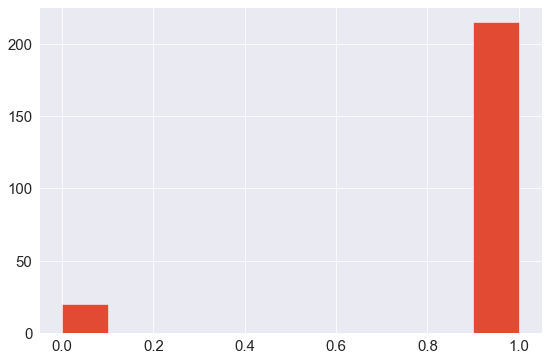

In [269]:
Y.hist(figsize=(9,6), xlabelsize=15, ylabelsize=15) #Еще одна проверка

In [335]:
sb.LikeDegree = Y #Внесем изменение в исходный датафрейм

---

### Строим модели
<b>Разбобьем выборку на обучающую и тестовую.</b>

In [271]:
import sklearn.metrics

In [272]:
XX = (sb.select_dtypes(include=['int64', 'float64']).drop('LikeDegree', axis=1))
#Y уже задано

In [273]:

x_train, x_test, y_train, y_test = tts(XX, Y, test_size=0.3, random_state=200000, stratify=Y)

print(x_train.shape)
print(x_test.shape)


(164, 10)
(71, 10)


In [274]:
y_train.value_counts()/len(y_train)

1    0.914634
0    0.085366
Name: LikeDegree, dtype: float64

In [275]:
y_test.value_counts()/len(y_test)

1    0.915493
0    0.084507
Name: LikeDegree, dtype: float64

Распределения на обучающей и тестовой выборках очень похожи => мы делаем хорошие предсказания.

Также по полученным значениям еще раз понятно, что accuracy не подойдет для оценки качества (сильный дизбаланс)

---

<b>Построим наивную модель предсказания для целевой переменной.</b>

In [276]:

y_pn = np.ones(len(y_test)) #Спрогнозировали по Все студенты довольны (=1)
y_pn #Вывели наивный прогноз



array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

<b>Построем модели ближайших соседей для 3, 5, 7 соседей. </b>

In [277]:
x_train, x_test = x_train[rv], x_test[rv] 
#Возьмем только непрерывные переменные, выделенные ранее.

In [278]:
y_train, y_test = y_train.astype('int64'), y_test.astype('int64') 
#Переведем в числовой формат (иначе Knn выдаст ошибку).

In [279]:

kn3 = knn(n_neighbors = 3) #3 соседей.
kn5 = knn(n_neighbors = 5) #5 соседей.
kn7 = knn(n_neighbors = 7) #7 соседей.



In [280]:
#Работаем с 3 соседями:

kn3.fit(x_train, y_train) #обучаем по тренировочной
y_pkn3 = kn3.predict(x_test) #проверяем на тестовой

y_pkn3 #Прогноз


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int64)

In [281]:
#Работаем с 5 соседями:

kn5.fit(x_train, y_train) #обучаем по тренировочной
y_pkn5 = kn5.predict(x_test) #проверяем на тестовой

y_pkn5 #Прогноз


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int64)

In [287]:
#Работаем с 7 соседями:

kn7.fit(x_train, y_train) #обучаем по тренировочной
y_pkn7 = kn7.predict(x_test) #проверяем на тестовой

y_pkn7 #Прогноз


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int64)

<b>После того, как модели построены, попробуем их оценить по несольким метрикам качества:</b>

In [288]:
#Качество наивного прогноза:

precision_score(y_test, y_pn)



0.9154929577464789

In [289]:
recall_score(y_test, y_pn)

1.0

In [290]:
f1_score(y_test, y_pn)

0.9558823529411764

-----------------------------------------------------------

In [291]:
#Качество прогноза для 3 соседей:

precision_score(y_test, y_pkn3)



0.9154929577464789

In [292]:
recall_score(y_test, y_pkn3)

1.0

In [293]:
f1_score(y_test, y_pkn3)

0.9558823529411764

---------------------------

In [294]:
#Качество прогноза для 5 соседей:

precision_score(y_test, y_pkn5)



0.9154929577464789

In [295]:
recall_score(y_test, y_pkn5)

1.0

In [296]:
f1_score(y_test, y_pkn5)

0.9558823529411764

-----------------

In [297]:
#Качество прогноза для 7 соседей:

precision_score(y_test, y_pkn7)



0.9154929577464789

In [298]:
recall_score(y_test, y_pkn7)

1.0

In [299]:
f1_score(y_test, y_pkn7)

0.9558823529411764

На разных выборках (наивной, при 3, 5 и 7 соседях) метрики качества выдали одинаковые результаты.
Ни одна модель не превосходит другую.

---

<b>Применим шкалирование (MinMaxScaller).</b>

In [300]:

s = mms()

s.fit(x_train)
x_ntrain, x_ntest = s.transform(x_train), s.transform(x_test)


In [301]:
 
k_n3 = knn(n_neighbors=3) #3 соседей.
k_n5 = knn(n_neighbors=5) #5 соседей.
k_n7 = knn(n_neighbors=7) #7 соседей.


---

In [302]:
#Работаем с 3 соседями: 

k_n3.fit(x_ntrain, y_train) #обучаем по тренировочной
y_pk_n3 = k_n3.predict(x_ntest) #проверяем на тестовой

y_pk_n3 #Прогноз



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int64)

In [303]:
#Качество прогноза для 3 соседей:

precision_score(y_test, y_pk_n3) #То же самое качество

0.9154929577464789

In [304]:
recall_score(y_test, y_pk_n3) #То же самое качество

1.0

In [305]:
f1_score(y_test, y_pk_n3) #То же самое качество

0.9558823529411764

-----------

In [306]:
#Работаем с 5 соседями:

k_n5.fit(x_ntrain, y_train) #обучаем по тренировочной
y_pk_n5 = k_n5.predict(x_ntest) #проверяем на тестовой

y_pk_n5 #Прогноз



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int64)

In [307]:
#Качество прогноза для 5 соседей:

precision_score(y_test, y_pk_n5) #То же самое качество

0.9154929577464789

In [308]:
recall_score(y_test, y_pk_n5) #То же самое качество

1.0

In [309]:
f1_score(y_test, y_pk_n5) #То же самое качество

0.9558823529411764

---

In [310]:
#Работаем с 7 соседями:

k_n7.fit(x_ntrain, y_train) #обучаем по тренировочной
y_pk_n7 = k_n7.predict(x_ntest) #проверяем на тестовой

y_pk_n7 #Прогноз



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int64)

In [311]:
#Качество прогноза для 7 соседей:

precision_score(y_test, y_pk_n7) #То же самое качество

0.9154929577464789

In [312]:
recall_score(y_test, y_pk_n7) #То же самое качество

1.0

In [313]:
f1_score(y_test, y_pk_n7) #То же самое качество

0.9558823529411764


<h3 style='color: #E88975;'>Все оценки качества остались прежними, шкалирование не помогло</h3>


---

<b>Тогда попробуем удалить выбросы в имеющихся признаках.</b>

In [314]:

sbn = sb.copy()

for i in list(sbn[rv]):
    q1, q3 = np.percentile(sb[i], 25), np.percentile(sb[i], 75)
    mx, mn = q3 + 1.5*(q3-q1), q1 - 1.5*(q3-q1)
    sbn[i] = sbn[i].loc[(sbn[i] >= mn) & (sbn[i] <= mx)]
sbn = sbn.dropna()


#sbn

---

In [315]:

Y = sbn.LikeDegree 
X = sbn.copy().drop('LikeDegree', axis=1) 

x_train, x_test, y_train, y_test = tts(X, Y, test_size=0.3, random_state=200000, stratify=Y)


print(x_train.shape)
print(x_test.shape)


(92, 18)
(40, 18)


In [316]:
x_train, x_test = x_train[rv], x_test[rv] 
#Возьмем только непрерывные переменные, выделенные ранее, чтобы knn работал.

In [317]:
y_train, y_test = y_train.astype('int64'), y_test.astype('int64') 
#Переведем в числовой формат (иначе Knn выдаст ошибку).

---

In [318]:
#Работаем с наивной выборкой:

y_pn = np.ones(len(y_test)) #Спрогнозировали по Все студенты довольны (=1)
y_pn #Вывели наивный прогноз


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [319]:
precision_score(y_test, y_pn)

0.925

In [320]:
recall_score(y_test, y_pn)

1.0

In [321]:
f1_score(y_test, y_pn)

0.961038961038961

---

In [322]:
kn3 = knn(n_neighbors = 3) #3 соседей.
kn5 = knn(n_neighbors = 5) #5 соседей.
kn7 = knn(n_neighbors = 7) #7 соседей.

In [323]:
#Работаем с 3 соседями:

kn3.fit(x_train, y_train) #обучаем по тренировочной
y_kn3 = kn3.predict(x_test) #проверяем на тестовой

y_kn3 #Прогноз

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [324]:
precision_score(y_test, y_kn3)

0.925

In [325]:
recall_score(y_test, y_kn3)

1.0

In [326]:
f1_score(y_test, y_kn3)

0.961038961038961

---

In [327]:
#Работаем с 5 соседями:

kn5.fit(x_train, y_train) #обучаем по тренировочной
y_kn5 = kn5.predict(x_test) #проверяем на тестовой

y_kn5 #Прогноз


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [328]:
precision_score(y_test, y_kn5)

0.925

In [329]:
recall_score(y_test, y_kn5)

1.0

In [330]:
f1_score(y_test, y_kn5)

0.961038961038961

---

In [331]:
#Работаем с 7 соседями:

kn7.fit(x_train, y_train) #обучаем по тренировочной
y_kn7 = kn7.predict(x_test) #проверяем на тестовой

y_kn7 #Прогноз


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [332]:
precision_score(y_test, y_kn7)

0.925

In [333]:
recall_score(y_test, y_kn7)

1.0

In [334]:
f1_score(y_test, y_kn7)

0.961038961038961

Результаты качеств изменились после удаления выбросов, но по прежнему все метрики качеств выдают равные результаты.


Сложно в данном случае назвать лучшую модель, все они, скорее, некачественные, тк. вне зависимости от увеличения соседей, показатели метрик не меняются, более того, качественность моделей остается такой же, как и при наивном прогнозе, что очень плохо, обычно при изменении кол-ва соседей можно отслеживать моменты "обучения" и "переобучения" машины, когда качественность прогнозов ухудшается. В данном же случае, такого не происходит, поэтому создается впечатление, что мышина не обучается. Возможно проблема в дисбалансе классов или маленькой выборке, либо в том и в другом вместе. 

Если приходится оценивать модели из имеющихся, то ВСЕ модели (наивная; при 3, 5, 7 соседях) после удаления выбросов имеют более высокие результаты предсказаний (тк. значения метрик качества выше).



---